<a href="https://colab.research.google.com/github/sakamoto-hands-on/Python_Practical_DataAnalysis100/blob/master/07_Optimizing_LogisticsNetworkDesign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#製造から物流までの全体の流れとして、コスト改善を分析

##輸送最適化問題を解いてみる

In [6]:
!pip install pulp
!pip install ortoolpy

import numpy as np
import pandas as pd
from itertools import product
from pulp import LpVariable, lpSum, value
from ortoolpy import model_min, addvars, addvals


  Created wheel for ortoolpy: filename=ortoolpy-0.2.30-cp36-none-any.whl size=23236 sha256=e6ceeb39dcb9ee03eb46f766226f7a5fc2fc7e3bcac425f6bf3019dd00829c85
  Stored in directory: /root/.cache/pip/wheels/04/b2/96/f6ef2da1545a11cd91ee4bd9da930d588dde5751ac7e088a74
Successfully built ortoolpy


In [0]:
df_tc = pd.read_csv('trans_cost.csv', index_col="工場")
df_demand = pd.read_csv('demand.csv')
df_supply = pd.read_csv('supply.csv')


In [0]:
np.random.seed(1)
nw = len(df_tc.index)
nf = len(df_tc.columns)
pr = list(product(range(nw), range(nf)))

数理モデル作成

In [9]:
m1 = model_min()
v1 ={(i,j):LpVariable('v%d_%d'%(i,j),lowBound=0) for i,j in pr}

m1 += lpSum(df_tc.iloc[i][j]*v1[i,j] for i,j in pr)
for i in range(nw):
  m1 += lpSum(v1[i,j] for j in range(nf)) <= df_supply.iloc[0][i]
for j in range(nf):
  m1 += lpSum(v1[i,j] for i in range(nw)) >= df_demand.iloc[0][i]
m1.solve()

-1

総輸送コスト計算

In [10]:
df_tr_sol = df_tc.copy()
total_cost = 0
for k,x in v1.items():
  i,j = k[0],k[1]
  df_tr_sol.iloc[i][j] = value(x)
  total_cost += df_tc.iloc[i][j]*value(x)

print(df_tr_sol)
print("総輸送コスト：" + str(total_cost))

    F1  F2  F3  F4
工場                
W1  31   4   0   0
W2   0   0  31  16
W3   0  27   0  15
総輸送コスト：1450.0


##最適輸送ルートをネットワークで確認

In [0]:
import matplotlib.pyplot as plt
import networkx as nx

df_tr = pd.read_csv('trans_route.csv', index_col="工場")
df_pos = pd.read_csv('trans_route_pos.csv')

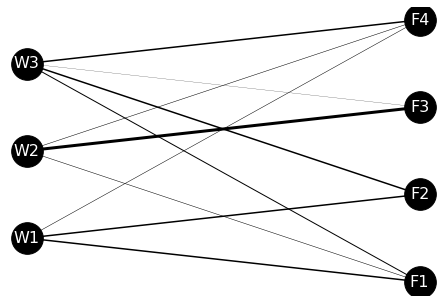

In [14]:
G = nx.Graph()

for i in range(len(df_pos.columns)):
  G.add_node(df_pos.columns[i])

num_pre = 0
edge_weights = []
size = 0.1
for i in range(len(df_pos.columns)):
  for j in range(len(df_pos.columns)):
    if not (i==j):
      G.add_edge(df_pos.columns[i],df_pos.columns[j])
      if num_pre<len(G.edges):
        num_pre = len(G.edges)
        weight = 0
        if (df_pos.columns[i] in df_tr.columns)and(df_pos.columns[j] in df_tr.index):
          if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
            weight = df_tr[df_pos.columns[i][df_pos.columns][j]]*size
        elif (df_pos.columns[j] in df_tr.columns)and(df_pos.columns[i] in df_tr.index):
          if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
            weight = df_tr[df_pos.columns[j]][df_pos.columns[i]]*size
        edge_weights.append(weight)

pos={}
for i in range(len(df_pos.columns)):
  node = df_pos.columns[i]
  pos[node] = (df_pos[node][0],df_pos[node][1])

nx.draw(G,pos,with_labels=True,font_size=16,node_size=1000,node_color='k',font_color='w',width=edge_weights)

plt.show()

##最適ルートが制約条件内におさまっているかどうかを確認

制約条件計算関数

In [0]:
def condition_demand(df_tr,df_demand):
  flag = np.zeros(len(df_demand.columns))
  for i in range(len(df_demand.columns)):
    temp_sum = sum(df_tr[df_demand.columns[i]])
    if (temp_sum)>=df_demand.iloc[0][i]):
      flag[i] = 1
  return flag

In [0]:
def condition_supply(df_tr,df_supply):
  flag = np.zeros(len(df_supply.columns))
  for i in range(len(df_supply.columns)):
    temp_sum = sum(df_tr.loc[df_supply.columns[i]])
    if temp_sum>=df_supply.iloc[0][i]:
      flag[i] = 1
  return flag

In [17]:
print("需要条件計算結果：" + str(condition_demand(df_tr_sol,df_demand)))
print("供給条件計算結果：" + str(condition_supply(df_tr_sol,df_supply)))

需要条件計算結果：[1. 1. 1. 1.]
供給条件計算結果：[1. 1. 1.]


##生産計画に関するデータを読み込む

In [18]:
df_material = pd.read_csv('product_plan_material.csv', index_col="製品")
print(df_material)

     原料1  原料2  原料3
製品                
製品1    1    4    3
製品2    2    4    1


In [21]:
df_profit = pd.read_csv('product_plan_profit.csv', index_col="製品")
print(df_profit)

      利益
製品      
製品1  5.0
製品2  4.0


In [22]:
df_stock = pd.read_csv('product_plan_stock.csv', index_col="項目")
print(df_stock)

    原料1  原料2  原料3
項目               
在庫   40   80   50


In [23]:
df_plan = pd.read_csv('product_plan.csv', index_col="製品")
print(df_plan)

      生産量
製品       
製品1    16
製品2     0


##利益を計算する関数を作る

In [24]:
def product_plan(df_profit,df_plan):
  profit = 0
  for i in range(len(df_profit.index)):
    for j in range(len(df_plan.columns)):
      profit += df_profit.iloc[i][j]*df_plan.iloc[i][j]
  return profit

print("総利益：" + str(product_plan(df_profit, df_plan)))

総利益：80.0


##生産最適化問題を解く

In [27]:
from ortoolpy import model_max
df = df_material.copy()
inv = df_stock

m = model_max()
v1 = {(i):LpVariable('v%d'%(i),lowBound=0) for i in range(len(df_profit))}
m += lpSum(df_profit.iloc[i]*v1[i] for i in range(len(df_profit)))
for i in range(len(df_material.columns)):
  m += lpSum(df_material.iloc[j,i]*v1[j] for j in range(len(df_profit))) <= df_stock.iloc[:,i]
m.solve()

1

In [29]:
v1

{0: v0, 1: v1}

In [28]:
df_plan_sol = df_plan.copy()
for k,x in v1.items():
  df_plan_sol.iloc[k] = value(x)
print(df_plan_sol)
print("総利益： " + str(value(m.objective)))

      生産量
製品       
製品1  15.0
製品2   5.0
総利益： 95.0


##最適生産計画が制約条件内におさまっているかどうかを確認

それぞれの原料の使用量がどの程度であり、それが在庫を効率よく利用できているかを調べる

In [30]:
def condition_stock(df_plan,df_material,df_stock):
  flag = np.zeros(len(df_material.columns))
  for i in range(len(df_material.columns)):
    temp_sum = 0
    for j in range(len(df_material.index)):
      temp_sum = temp_sum + df_material.iloc[j][i]*float(df_plan.iloc[j])
    if (temp_sum<=float(df_stock.iloc[0][i])):
      flag[i]=1
    print(df_material.columns[i]+ " 使用量：" + str(temp_sum) + ", 在庫：" + str(float(df_stock.iloc[0][i])))
  return flag

print("制約条件計算結果：" + str(condition_stock(df_plan_sol,df_material,df_stock)))

原料1 使用量：25.0, 在庫：40.0
原料2 使用量：80.0, 在庫：80.0
原料3 使用量：50.0, 在庫：50.0
制約条件計算結果：[1. 1. 1.]


##ロジスティクスネットワーク設計問題を解く

輸送コストと製造コストが、需要を満たしつつ最小になるように定式化
目的関数としては輸送コストと製造コストの和を与え、制約条件としては各商店での販売数が需要数を上回ることを考える

In [0]:
製品 = list('AB')
需要地 = list('PQ')
工場 = list('XY')
レーン = (2,2)

輸送費表

In [32]:
tbdi = pd.DataFrame(((j,k) for j in 需要地 for k in 工場), columns=['需要地','工場'])
tbdi['輸送費'] = [1,2,3,1]
print(tbdi)

  需要地 工場  輸送費
0   P  X    1
1   P  Y    2
2   Q  X    3
3   Q  Y    1


需要表

In [33]:
tbde = pd.DataFrame(((j,i) for j in 需要地 for i in 製品), columns=['需要','製品'])
tbde['需要'] = [10,10,20,20]
print(tbde)

   需要 製品
0  10  A
1  10  B
2  20  A
3  20  B


生産表

In [34]:
tbfa = pd.DataFrame(((k,l,i,0,np.inf) for k,nl in zip (工場,レーン) for l in range(nl) for i in 製品), columns=['工場','レーン','製品','下限','上限'])
tbfa['生産費'] = [1,np.nan,np.nan,1,3,np.nan,5,3]
tbfa.dropna(inplace=True)
tbfa.loc[4,'上限']=10
print(tbfa)

  工場  レーン 製品  下限    上限  生産費
0  X    0  A   0   inf  1.0
3  X    1  B   0   inf  1.0
4  Y    0  A   0  10.0  3.0
6  Y    1  A   0   inf  5.0
7  Y    1  B   0   inf  3.0


In [36]:
from ortoolpy import logistics_network
_, tbdi2, _ = logistics_network(tbde,tbdi,tbfa)
print(tbfa)
print(tbdi2)

  工場  レーン 製品  下限    上限  生産費     VarY  ValY
0  X    0  A   0   inf  1.0  v000022  40.0
3  X    1  B   0   inf  1.0  v000023  40.0
4  Y    0  A   0  10.0  3.0  v000024   0.0
6  Y    1  A   0   inf  5.0  v000025   0.0
7  Y    1  B   0   inf  3.0  v000026   0.0
  需要地 工場  輸送費 製品     VarX  ValX
0   P  X    1  A  v000014  20.0
1   P  X    1  B  v000015  20.0
2   Q  X    3  A  v000016  20.0
3   Q  X    3  B  v000017  20.0
4   P  Y    2  A  v000018   0.0
5   P  Y    2  B  v000019   0.0
6   Q  Y    1  A  v000020   0.0
7   Q  Y    1  B  v000021   0.0


##最適ネットワークにおける輸送コストとその内訳を計算

輸送費のカラムと、最適輸送量を格納するValXのカラムをかけ合わせることで、輸送コストが計算できる

In [37]:
print(tbdi2)
trans_cost = 0
for i in range(len(tbdi2.index)):
  trans_cost += tbdi2["輸送費"].iloc[i]*tbdi2["ValX"].iloc[i]
print("総輸送コスト：" + str(trans_cost))

  需要地 工場  輸送費 製品     VarX  ValX
0   P  X    1  A  v000014  20.0
1   P  X    1  B  v000015  20.0
2   Q  X    3  A  v000016  20.0
3   Q  X    3  B  v000017  20.0
4   P  Y    2  A  v000018   0.0
5   P  Y    2  B  v000019   0.0
6   Q  Y    1  A  v000020   0.0
7   Q  Y    1  B  v000021   0.0
総輸送コスト：160.0
